In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sklearn.preprocessing as preprocess
from collections import Counter
import pprint
from scipy.stats import chisquare
from sklearn.decomposition import PCA
import seaborn as sns

pp = pprint.PrettyPrinter(indent=4)

In [7]:
df = pd.read_csv("topCharts_continuous.csv", index_col = 0)

In [14]:
unique_df = df.drop_duplicates(subset = ["Artist", "Title"])

In [17]:
cnt_df = unique_df.select_dtypes(exclude = ["object"])

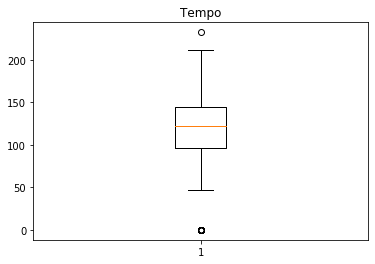

count    3442.000000
mean      121.038451
std        33.014516
min         0.000000
25%        96.052500
50%       121.979500
75%       144.987250
max       232.690000
Name: Tempo, dtype: float64


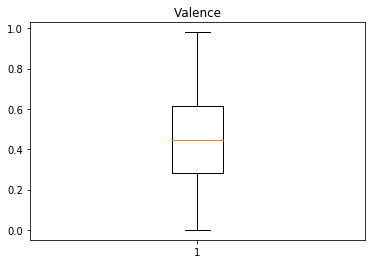

count    3442.000000
mean        0.451808
std         0.221824
min         0.000000
25%         0.281000
50%         0.447500
75%         0.616000
max         0.980000
Name: Valence, dtype: float64


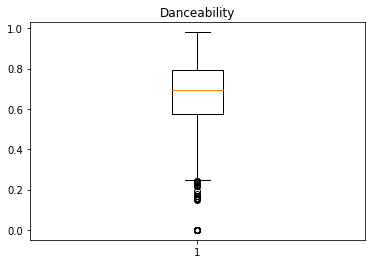

count    3442.000000
mean        0.671981
std         0.171187
min         0.000000
25%         0.575000
50%         0.694000
75%         0.793000
max         0.980000
Name: Danceability, dtype: float64


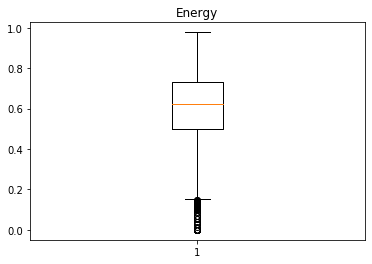

count    3442.000000
mean        0.603461
std         0.184598
min         0.000000
25%         0.501000
50%         0.623000
75%         0.734000
max         0.978000
Name: Energy, dtype: float64


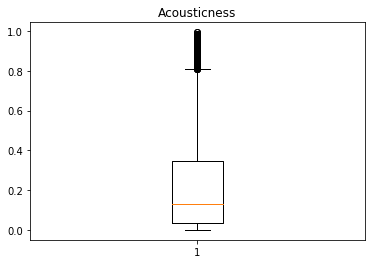

count    3442.000000
mean        0.231992
std         0.255571
min         0.000000
25%         0.036825
50%         0.131000
75%         0.345750
max         0.994000
Name: Acousticness, dtype: float64


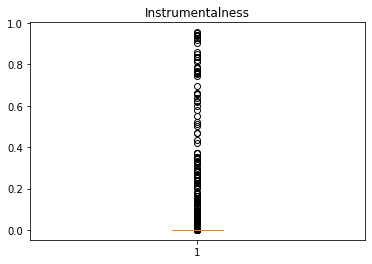

count    3442.000000
mean        0.013938
std         0.087467
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000021
max         0.956000
Name: Instrumentalness, dtype: float64


In [18]:
for c in cnt_df.columns:
    plt.boxplot(cnt_df[c])
    plt.title(c)
    plt.show()
    print(cnt_df[c].describe())

In [29]:
cnt_df = cnt_df.drop(columns = ["Instrumentalness"])

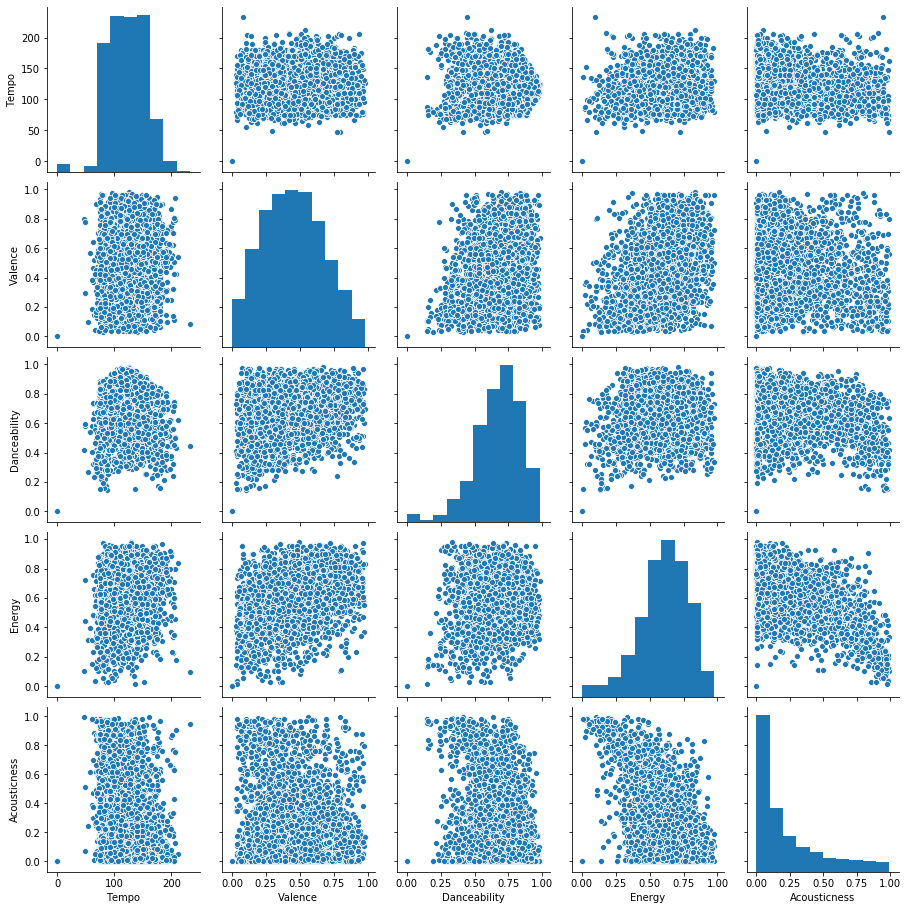

In [30]:
sns.pairplot(cnt_df.iloc[:,:])

In [31]:
cnt_df.corr()

,Tempo,Valence,Danceability,Energy,Acousticness
Tempo,1.000000,0.108260,0.205470,0.250439,-0.098454
Valence,0.108260,1.000000,0.296552,0.398377,-0.067547
Danceability,0.205470,0.296552,1.000000,0.217410,-0.234344
Energy,0.250439,0.398377,0.217410,1.000000,-0.465617
Acousticness,-0.098454,-0.067547,-0.234344,-0.465617,1.000000


In [32]:
cluster_cols = cnt_df.columns

In [33]:
def scaleData(scaler, df, col_list = cluster_cols):
    
    """
    normalizes continuous values in dataframe
    
    inputs:  scaler:    one of the scaler functions from sklearn.preprocessing
             song_df:   dataframe of songs (with titles) 
             firstCol:  index of first column of continuous values to be rescaled in song_df 
    
    returns: dataframe of songs (with titles) with rescaled continuous values
    """
    
    scaled_df = df.copy()
        
    cluster_values = df.loc[:,col_list]
    mms = scaler()
    mms.fit(cluster_values)
    scaled_values = mms.transform(cluster_values)
    
    for i in range(scaled_values.shape[1]):
        scaled_df[col_list[i]] = scaled_values[:,i]

    return scaled_df

In [34]:
scaled_df = scaleData(preprocess.MinMaxScaler, unique_df)

In [35]:
scaled_df.head()

,Artist,Title,Tempo,Valence,Danceability,Energy,Acousticness,Instrumentalness
0,Post Malone,rockstar,0.686755,0.131633,0.596939,0.531697,0.124748,0.000070
1,G-Eazy,No Limit,0.756186,0.413265,0.855102,0.788344,0.011771,0.000000
2,Lil Pump,Gucci Gang,0.515231,0.713265,0.955102,0.534765,0.240443,0.000000
3,Cardi B,Bartier Cardi (feat. 21 Savage),0.593128,0.111224,0.926531,0.535787,0.001117,0.000678
4,Camila Cabello,Havana,0.451193,0.402041,0.780612,0.534765,0.185111,0.000036


In [38]:
def apply_pca(scaled_df, n, col_list = cluster_cols):
    """
    applies PCA to dataframe and attaches resulting PCA values as columns to end of dataframe
    
    inputs:  scaled_df:  dataframe of songs (with titles) with scaled continuous values
             n:          number of desired principal components
             firstCol:   index of first column of continuous values
             
    returns: scaled_df with principal component columns appended to end 
    """  
    
    pca = PCA(n_components=n)
    principalComponents = pca.fit_transform(scaled_df.loc[:,col_list])
    pca_df = scaled_df.copy()
    for i in range(n):
        pca_df[f"pc{i+1}"] = principalComponents[:,i]
        
    return pca_df
    

In [40]:
pca_df = apply_pca(scaled_df, 2)

In [41]:
pca_df.head()

,Artist,Title,Tempo,Valence,Danceability,Energy,Acousticness,Instrumentalness,pc1,pc2
0,Post Malone,rockstar,0.686755,0.131633,0.596939,0.531697,0.124748,0.000070,0.099029,-0.334471
1,G-Eazy,No Limit,0.756186,0.413265,0.855102,0.788344,0.011771,0.000000,-0.300084,-0.104511
2,Lil Pump,Gucci Gang,0.515231,0.713265,0.955102,0.534765,0.240443,0.000000,-0.130420,0.240464
3,Cardi B,Bartier Cardi (feat. 21 Savage),0.593128,0.111224,0.926531,0.535787,0.001117,0.000678,-0.063930,-0.370240
4,Camila Cabello,Havana,0.451193,0.402041,0.780612,0.534765,0.185111,0.000036,0.011123,-0.070363


In [42]:
def fitKMeans(scaled_df, minCluster, maxCluster, col_list):
    """
    applies k-means clustering to dataframe and plots inertia and change in inertia for corresponding to number of clusters
    
    inputs:   df:          dataframe with only continuous values
              minCluster:  smallest number of desired clusters
              maxClusters: largest number of desired clusters
              col_list:    columns to cluster on
    
    returns:  list of intertias corresponding to number of clusters ranging from minCluster to maxCluster
    
    """

    df = scaled_df.loc[:,col_list]
    
    
    inertias = []
    for i in range(minCluster, maxCluster+1):
        kmeans = KMeans(n_clusters = i).fit(df)
        inertias.append(kmeans.inertia_)    
    
    plt.plot(range(1,len(inertias)+1), inertias, "bx-")
    plt.xlabel('k')
    plt.ylabel("Inertia")
    plt.xticks(range(1,len(inertias)+1))
    plt.show()
    
    
    diffs = np.array(inertias[1:]) - np.array(inertias[:len(inertias)-1])
    plt.plot(range(1,len(inertias)+1), [-inertias[0]] + list(diffs),"bx-")
    plt.ylabel("Change in Inertia")
    plt.xticks(range(1,len(inertias)+1))

    plt.show()
    
    return inertias
    

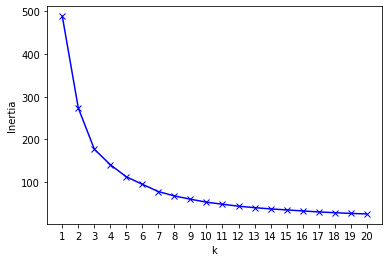

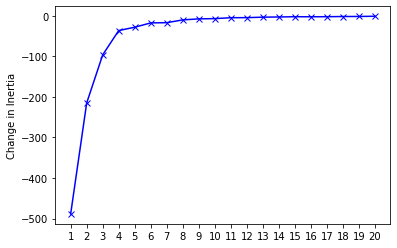

In [43]:
inertias = fitKMeans(pca_df, 1, 20, ["pc1","pc2"])

In [45]:
def fitKMeans(scaled_df, k, col_list):
    """
    applies k-means clustering with k clusters to dataframe
    
    inputs:   song_df:      dataframe of songs (with titles)
              clusters:  number of desired clusters
              col_list: list of column indexes to cluster on
            
    returns:  dataframe of songs with cluster number
              dict of dataframes {cluster number: subset of song_df with songs belonging to cluster}
              dict of Counters   {cluster number: Counter(artist, number of times artist appears in cluster)}
    """
    
    kmeans_opt = KMeans(n_clusters = k).fit(scaled_df.loc[:,col_list])
    labels_df = scaled_df.copy()
    labels_df["Label"] = kmeans_opt.labels_
    
    return labels_df

In [52]:
k = 5

In [53]:
cluster_df = fitKMeans(pca_df, k, ["pc1","pc2"])

In [54]:
cluster_df.head()

,Artist,Title,Tempo,Valence,Danceability,Energy,Acousticness,Instrumentalness,pc1,pc2,Label
0,Post Malone,rockstar,0.686755,0.131633,0.596939,0.531697,0.124748,0.000070,0.099029,-0.334471,0
1,G-Eazy,No Limit,0.756186,0.413265,0.855102,0.788344,0.011771,0.000000,-0.300084,-0.104511,3
2,Lil Pump,Gucci Gang,0.515231,0.713265,0.955102,0.534765,0.240443,0.000000,-0.130420,0.240464,3
3,Cardi B,Bartier Cardi (feat. 21 Savage),0.593128,0.111224,0.926531,0.535787,0.001117,0.000678,-0.063930,-0.370240,0
4,Camila Cabello,Havana,0.451193,0.402041,0.780612,0.534765,0.185111,0.000036,0.011123,-0.070363,0


In [55]:
def getClusterSubset(cluster_df, cluster_idx):
    return cluster_df[cluster_df.Label == cluster_idx]

In [56]:
def getClusterArtistCount(cluster_df_subset):
    return Counter(cluster_df_subset["Artist"])

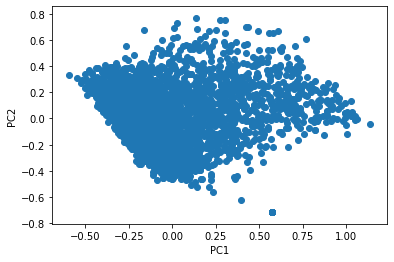

In [57]:
plt.scatter(cluster_df["pc1"], cluster_df["pc2"])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

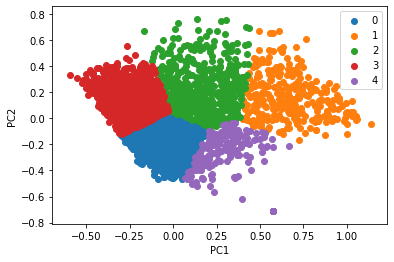

In [59]:
cluster_subsets = [getClusterSubset(cluster_df, i) for i in range(k)]
for i in range(len(cluster_subsets)):
    sub = cluster_subsets[i]
    plt.scatter(sub["pc1"], sub["pc2"], label = i)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

In [60]:
def getClusterSongs(cluster_df, cluster_idx, top = 0):
    
    sub = getClusterSubset(cluster_df, cluster_idx)
    artcounts = getClusterArtistCount(sub)
    
    songs = dict()
    for artist in artcounts.keys():
        songs[artist] = list(sub.loc[sub.Artist == artist, "Title"])
        
    
    if top == 0:
        return songs

    else:
        return {a[0]:songs[a[0]] for a in artcounts.most_common(top)}

In [61]:
pp.pprint(getClusterSongs(cluster_df, 1, 5))

{   'Billie Eilish': [   'lovely (with Khalid)',
                         'ocean eyes',
                         "when the party's over",
                         'bitches broken hearts',
                         'come out and play',
                         'lovely',
                         'WHEN I WAS OLDER - Music Inspired By The Film ROMA',
                         'bury a friend',
                         'xanny',
                         '8',
                         'listen before i go',
                         'i love you',
                         'goodbye',
                         'everything i wanted'],
    'Bing Crosby': [   'White Christmas',
                       'Winter Wonderland',
                       'Do You Hear What I Hear?',
                       'The Little Drummer Boy',
                       "It's Beginning To Look Like Christmas",
                       'What Child Is This?/The Holly And The Ivy',
                       'God Rest Ye Merry Gentlemen',
   